# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

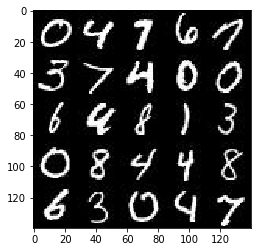

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

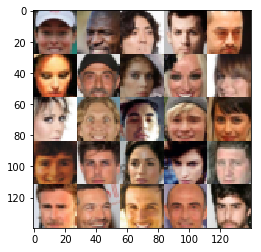

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_height, image_width, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    resized_images = tf.image.resize_images(images, [32, 32], align_corners=True)
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(resized_images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(0.2*x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(0.2*x2, x2)

        x3 = tf.layers.conv2d(x1, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(0.2*x3, x3)

        flat = tf.reshape(x3, [-1, 4*4*256])
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 4*4*256)
        x1 = tf.reshape(x1, [-1, 4, 4, 256])
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.2 * x1, x1)
        # 4x4x512 now

        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2 * x2, x2)
        # 8x8x256 now

        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.2 * x3, x3)
        # 16x16x128 now

        # Output layer
        x3 = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 32x32x3 now

        logits = tf.image.resize_images(x3, [28, 28], align_corners=True)
        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_out = generator(input_z, out_channel_dim, is_train=True)
    d_out_real, d_logits_real = discriminator(input_real, reuse=False)
    d_out_fake, d_logits_fake = discriminator(g_out, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, labels=tf.ones_like(d_logits_real )
    ))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake )
    ))
    d_loss = d_loss_fake + d_loss_real

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_logits_fake )
    ))

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_op, g_train_op = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_train_op, feed_dict={input_real: batch_images, input_z: batch_z,})
                _ = sess.run(g_train_op, feed_dict={input_real: batch_images, input_z: batch_z})


                train_loss_d = d_loss.eval(feed_dict={input_real: batch_images, input_z: batch_z})
                train_loss_g = g_loss.eval(feed_dict={input_z: batch_z})

                print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                
            show_generator_output(sess, 36, input_z,  data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/10... Discriminator Loss: 1.7945... Generator Loss: 0.2570
Epoch 1/10... Discriminator Loss: 1.5162... Generator Loss: 0.3125
Epoch 1/10... Discriminator Loss: 0.9823... Generator Loss: 0.5666
Epoch 1/10... Discriminator Loss: 0.9472... Generator Loss: 0.5959
Epoch 1/10... Discriminator Loss: 1.1023... Generator Loss: 0.4890
Epoch 1/10... Discriminator Loss: 1.0045... Generator Loss: 0.5534
Epoch 1/10... Discriminator Loss: 1.1132... Generator Loss: 0.4904
Epoch 1/10... Discriminator Loss: 1.6364... Generator Loss: 0.2772
Epoch 1/10... Discriminator Loss: 1.6744... Generator Loss: 0.2899
Epoch 1/10... Discriminator Loss: 1.3254... Generator Loss: 0.4802
Epoch 1/10... Discriminator Loss: 1.7100... Generator Loss: 0.3313
Epoch 1/10... Discriminator Loss: 1.7380... Generator Loss: 0.3389
Epoch 1/10... Discriminator Loss: 1.0688... Generator Loss: 0.8042
Epoch 1/10... Discriminator Loss: 0.6802... Generator Loss: 1.3269
Epoch 1/10... Discriminator Loss: 0.6210... Generator Loss: 1.

Epoch 1/10... Discriminator Loss: 0.5670... Generator Loss: 1.6258
Epoch 1/10... Discriminator Loss: 0.5721... Generator Loss: 1.6318
Epoch 1/10... Discriminator Loss: 0.5273... Generator Loss: 1.6776
Epoch 1/10... Discriminator Loss: 0.5134... Generator Loss: 1.6884
Epoch 1/10... Discriminator Loss: 0.5009... Generator Loss: 1.6722
Epoch 1/10... Discriminator Loss: 0.5052... Generator Loss: 1.6918
Epoch 1/10... Discriminator Loss: 0.5118... Generator Loss: 1.6669
Epoch 1/10... Discriminator Loss: 0.4973... Generator Loss: 1.7137
Epoch 1/10... Discriminator Loss: 0.5294... Generator Loss: 1.7413
Epoch 1/10... Discriminator Loss: 0.5702... Generator Loss: 1.6466
Epoch 1/10... Discriminator Loss: 0.5811... Generator Loss: 1.6407
Epoch 1/10... Discriminator Loss: 0.6209... Generator Loss: 1.5329
Epoch 1/10... Discriminator Loss: 0.5784... Generator Loss: 1.6122
Epoch 1/10... Discriminator Loss: 0.6265... Generator Loss: 1.5009
Epoch 1/10... Discriminator Loss: 0.6403... Generator Loss: 1.

Epoch 1/10... Discriminator Loss: 0.9194... Generator Loss: 0.9524
Epoch 1/10... Discriminator Loss: 0.9717... Generator Loss: 1.0468
Epoch 1/10... Discriminator Loss: 0.9484... Generator Loss: 0.8926
Epoch 1/10... Discriminator Loss: 0.9702... Generator Loss: 1.1775
Epoch 1/10... Discriminator Loss: 0.9865... Generator Loss: 0.7693
Epoch 1/10... Discriminator Loss: 0.9666... Generator Loss: 1.1737
Epoch 1/10... Discriminator Loss: 0.9465... Generator Loss: 0.9893
Epoch 1/10... Discriminator Loss: 0.8977... Generator Loss: 1.1402
Epoch 1/10... Discriminator Loss: 0.9605... Generator Loss: 0.8557
Epoch 1/10... Discriminator Loss: 0.9573... Generator Loss: 1.3161
Epoch 1/10... Discriminator Loss: 1.0035... Generator Loss: 0.7275
Epoch 1/10... Discriminator Loss: 1.0440... Generator Loss: 1.5771
Epoch 1/10... Discriminator Loss: 0.9846... Generator Loss: 0.7687
Epoch 1/10... Discriminator Loss: 0.9434... Generator Loss: 1.2575
Epoch 1/10... Discriminator Loss: 0.9700... Generator Loss: 0.

Epoch 1/10... Discriminator Loss: 0.8421... Generator Loss: 1.3348
Epoch 1/10... Discriminator Loss: 0.9037... Generator Loss: 0.8262
Epoch 1/10... Discriminator Loss: 0.8778... Generator Loss: 1.2948
Epoch 1/10... Discriminator Loss: 0.8556... Generator Loss: 1.0793
Epoch 1/10... Discriminator Loss: 0.8884... Generator Loss: 0.9764
Epoch 1/10... Discriminator Loss: 0.8728... Generator Loss: 1.2103
Epoch 1/10... Discriminator Loss: 0.8646... Generator Loss: 0.9293
Epoch 1/10... Discriminator Loss: 0.8698... Generator Loss: 1.2999
Epoch 1/10... Discriminator Loss: 0.8807... Generator Loss: 0.8983
Epoch 1/10... Discriminator Loss: 0.8776... Generator Loss: 1.4301
Epoch 1/10... Discriminator Loss: 0.9279... Generator Loss: 0.7710
Epoch 1/10... Discriminator Loss: 0.9240... Generator Loss: 1.5172
Epoch 1/10... Discriminator Loss: 0.9115... Generator Loss: 0.7722
Epoch 1/10... Discriminator Loss: 0.8722... Generator Loss: 1.3772
Epoch 1/10... Discriminator Loss: 0.8683... Generator Loss: 0.

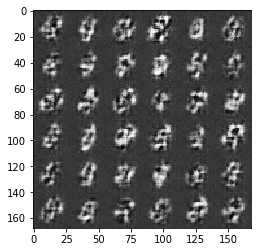

Epoch 2/10... Discriminator Loss: 0.7144... Generator Loss: 1.5328
Epoch 2/10... Discriminator Loss: 0.7502... Generator Loss: 0.9779
Epoch 2/10... Discriminator Loss: 0.7201... Generator Loss: 1.5702
Epoch 2/10... Discriminator Loss: 0.7408... Generator Loss: 1.0320
Epoch 2/10... Discriminator Loss: 0.7518... Generator Loss: 1.3778
Epoch 2/10... Discriminator Loss: 0.7134... Generator Loss: 1.1657
Epoch 2/10... Discriminator Loss: 0.7141... Generator Loss: 1.3530
Epoch 2/10... Discriminator Loss: 0.7318... Generator Loss: 1.0824
Epoch 2/10... Discriminator Loss: 0.7129... Generator Loss: 1.5340
Epoch 2/10... Discriminator Loss: 0.7401... Generator Loss: 0.9951
Epoch 2/10... Discriminator Loss: 0.7279... Generator Loss: 1.6656
Epoch 2/10... Discriminator Loss: 0.7641... Generator Loss: 0.9315
Epoch 2/10... Discriminator Loss: 0.7311... Generator Loss: 1.5035
Epoch 2/10... Discriminator Loss: 0.7272... Generator Loss: 1.0882
Epoch 2/10... Discriminator Loss: 0.7099... Generator Loss: 1.

Epoch 2/10... Discriminator Loss: 0.7319... Generator Loss: 0.9012
Epoch 2/10... Discriminator Loss: 0.6483... Generator Loss: 1.8772
Epoch 2/10... Discriminator Loss: 0.6665... Generator Loss: 1.0877
Epoch 2/10... Discriminator Loss: 0.6120... Generator Loss: 1.6519
Epoch 2/10... Discriminator Loss: 0.5759... Generator Loss: 1.3830
Epoch 2/10... Discriminator Loss: 0.6004... Generator Loss: 1.3554
Epoch 2/10... Discriminator Loss: 0.6031... Generator Loss: 1.5638
Epoch 2/10... Discriminator Loss: 0.6758... Generator Loss: 1.0698
Epoch 2/10... Discriminator Loss: 0.6209... Generator Loss: 1.8422
Epoch 2/10... Discriminator Loss: 0.5946... Generator Loss: 1.1962
Epoch 2/10... Discriminator Loss: 0.5676... Generator Loss: 1.6712
Epoch 2/10... Discriminator Loss: 0.6447... Generator Loss: 1.1918
Epoch 2/10... Discriminator Loss: 0.6133... Generator Loss: 1.6652
Epoch 2/10... Discriminator Loss: 0.6449... Generator Loss: 1.0814
Epoch 2/10... Discriminator Loss: 0.6250... Generator Loss: 1.

Epoch 2/10... Discriminator Loss: 0.5575... Generator Loss: 1.3045
Epoch 2/10... Discriminator Loss: 0.5417... Generator Loss: 1.9575
Epoch 2/10... Discriminator Loss: 0.5717... Generator Loss: 1.1924
Epoch 2/10... Discriminator Loss: 0.5423... Generator Loss: 1.8204
Epoch 2/10... Discriminator Loss: 0.5010... Generator Loss: 1.5890
Epoch 2/10... Discriminator Loss: 0.4897... Generator Loss: 1.5734
Epoch 2/10... Discriminator Loss: 0.4765... Generator Loss: 1.6664
Epoch 2/10... Discriminator Loss: 0.5314... Generator Loss: 1.3854
Epoch 2/10... Discriminator Loss: 0.5187... Generator Loss: 1.9066
Epoch 2/10... Discriminator Loss: 0.5602... Generator Loss: 1.2450
Epoch 2/10... Discriminator Loss: 0.5795... Generator Loss: 2.2343
Epoch 2/10... Discriminator Loss: 0.8197... Generator Loss: 0.7521
Epoch 2/10... Discriminator Loss: 0.6564... Generator Loss: 2.5140
Epoch 2/10... Discriminator Loss: 0.6656... Generator Loss: 1.0057
Epoch 2/10... Discriminator Loss: 0.5464... Generator Loss: 1.

Epoch 2/10... Discriminator Loss: 0.4434... Generator Loss: 1.7237
Epoch 2/10... Discriminator Loss: 0.4317... Generator Loss: 1.8295
Epoch 2/10... Discriminator Loss: 0.4502... Generator Loss: 1.6971
Epoch 2/10... Discriminator Loss: 0.4495... Generator Loss: 1.7501
Epoch 2/10... Discriminator Loss: 0.4433... Generator Loss: 1.7850
Epoch 2/10... Discriminator Loss: 0.4471... Generator Loss: 1.6991
Epoch 2/10... Discriminator Loss: 0.3970... Generator Loss: 1.9741
Epoch 2/10... Discriminator Loss: 0.5035... Generator Loss: 1.4278
Epoch 2/10... Discriminator Loss: 0.4690... Generator Loss: 1.8757
Epoch 2/10... Discriminator Loss: 0.4725... Generator Loss: 1.6309
Epoch 2/10... Discriminator Loss: 0.4523... Generator Loss: 1.7030
Epoch 2/10... Discriminator Loss: 0.4699... Generator Loss: 1.6655
Epoch 2/10... Discriminator Loss: 0.4256... Generator Loss: 1.7953
Epoch 2/10... Discriminator Loss: 0.4250... Generator Loss: 1.8814
Epoch 2/10... Discriminator Loss: 0.4413... Generator Loss: 1.

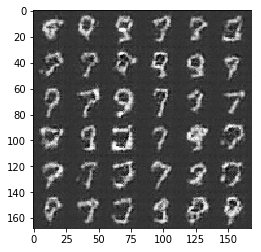

Epoch 3/10... Discriminator Loss: 0.5207... Generator Loss: 1.4736
Epoch 3/10... Discriminator Loss: 0.5510... Generator Loss: 2.0473
Epoch 3/10... Discriminator Loss: 0.5400... Generator Loss: 1.2900
Epoch 3/10... Discriminator Loss: 0.4992... Generator Loss: 1.9758
Epoch 3/10... Discriminator Loss: 0.6276... Generator Loss: 1.1131
Epoch 3/10... Discriminator Loss: 0.5856... Generator Loss: 2.3092
Epoch 3/10... Discriminator Loss: 0.6157... Generator Loss: 1.1052
Epoch 3/10... Discriminator Loss: 0.5649... Generator Loss: 2.5040
Epoch 3/10... Discriminator Loss: 0.5994... Generator Loss: 1.0938
Epoch 3/10... Discriminator Loss: 0.5227... Generator Loss: 2.1339
Epoch 3/10... Discriminator Loss: 0.4545... Generator Loss: 1.6396
Epoch 3/10... Discriminator Loss: 0.4943... Generator Loss: 1.6110
Epoch 3/10... Discriminator Loss: 0.4935... Generator Loss: 1.9323
Epoch 3/10... Discriminator Loss: 0.5234... Generator Loss: 1.4157
Epoch 3/10... Discriminator Loss: 0.5345... Generator Loss: 1.

Epoch 3/10... Discriminator Loss: 0.5762... Generator Loss: 1.2983
Epoch 3/10... Discriminator Loss: 0.5635... Generator Loss: 1.6294
Epoch 3/10... Discriminator Loss: 0.5665... Generator Loss: 1.4094
Epoch 3/10... Discriminator Loss: 0.5133... Generator Loss: 1.6980
Epoch 3/10... Discriminator Loss: 0.4789... Generator Loss: 1.8027
Epoch 3/10... Discriminator Loss: 0.5060... Generator Loss: 1.5610
Epoch 3/10... Discriminator Loss: 0.4700... Generator Loss: 1.7408
Epoch 3/10... Discriminator Loss: 0.5700... Generator Loss: 1.2447
Epoch 3/10... Discriminator Loss: 0.5473... Generator Loss: 2.3463
Epoch 3/10... Discriminator Loss: 0.5968... Generator Loss: 1.1585
Epoch 3/10... Discriminator Loss: 0.5600... Generator Loss: 2.2673
Epoch 3/10... Discriminator Loss: 0.8139... Generator Loss: 0.7841
Epoch 3/10... Discriminator Loss: 0.7608... Generator Loss: 2.6129
Epoch 3/10... Discriminator Loss: 0.6563... Generator Loss: 0.9970
Epoch 3/10... Discriminator Loss: 0.7474... Generator Loss: 2.

Epoch 3/10... Discriminator Loss: 0.5790... Generator Loss: 1.2794
Epoch 3/10... Discriminator Loss: 0.5276... Generator Loss: 1.9590
Epoch 3/10... Discriminator Loss: 0.5759... Generator Loss: 1.2158
Epoch 3/10... Discriminator Loss: 0.5796... Generator Loss: 2.0048
Epoch 3/10... Discriminator Loss: 0.5422... Generator Loss: 1.4619
Epoch 3/10... Discriminator Loss: 0.5742... Generator Loss: 1.5313
Epoch 3/10... Discriminator Loss: 0.5463... Generator Loss: 1.3833
Epoch 3/10... Discriminator Loss: 0.5968... Generator Loss: 1.6710
Epoch 3/10... Discriminator Loss: 0.5149... Generator Loss: 1.5146
Epoch 3/10... Discriminator Loss: 0.4774... Generator Loss: 1.7917
Epoch 3/10... Discriminator Loss: 0.4431... Generator Loss: 1.7323
Epoch 3/10... Discriminator Loss: 0.5780... Generator Loss: 1.2982
Epoch 3/10... Discriminator Loss: 0.5455... Generator Loss: 2.1564
Epoch 3/10... Discriminator Loss: 0.6708... Generator Loss: 0.9821
Epoch 3/10... Discriminator Loss: 0.5403... Generator Loss: 2.

KeyboardInterrupt: 

In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.8843... Generator Loss: 0.3030
Epoch 1/1... Discriminator Loss: 1.8698... Generator Loss: 0.2793
Epoch 1/1... Discriminator Loss: 1.6113... Generator Loss: 0.3626
Epoch 1/1... Discriminator Loss: 1.6029... Generator Loss: 0.3575
Epoch 1/1... Discriminator Loss: 1.6353... Generator Loss: 0.3472
Epoch 1/1... Discriminator Loss: 1.5138... Generator Loss: 0.4054
Epoch 1/1... Discriminator Loss: 1.6207... Generator Loss: 0.3689
Epoch 1/1... Discriminator Loss: 1.8185... Generator Loss: 0.3108
Epoch 1/1... Discriminator Loss: 1.5928... Generator Loss: 0.4107
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.5098
Epoch 1/1... Discriminator Loss: 1.6278... Generator Loss: 0.4171
Epoch 1/1... Discriminator Loss: 1.8964... Generator Loss: 0.3242
Epoch 1/1... Discriminator Loss: 2.0502... Generator Loss: 0.2692
Epoch 1/1... Discriminator Loss: 2.1067... Generator Loss: 0.2602
Epoch 1/1... Discriminator Loss: 1.5902... Generator Loss: 0.4728
Epoch 1/1.

Epoch 1/1... Discriminator Loss: 0.9102... Generator Loss: 0.9642
Epoch 1/1... Discriminator Loss: 0.8614... Generator Loss: 0.9832
Epoch 1/1... Discriminator Loss: 0.8796... Generator Loss: 0.9732
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 0.9402
Epoch 1/1... Discriminator Loss: 1.0359... Generator Loss: 0.8861
Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 0.8628
Epoch 1/1... Discriminator Loss: 1.0780... Generator Loss: 0.9380
Epoch 1/1... Discriminator Loss: 0.9525... Generator Loss: 1.0424
Epoch 1/1... Discriminator Loss: 0.9175... Generator Loss: 1.0767
Epoch 1/1... Discriminator Loss: 0.9099... Generator Loss: 1.0384
Epoch 1/1... Discriminator Loss: 1.0092... Generator Loss: 0.9279
Epoch 1/1... Discriminator Loss: 0.9655... Generator Loss: 0.9526
Epoch 1/1... Discriminator Loss: 0.9665... Generator Loss: 0.9976
Epoch 1/1... Discriminator Loss: 0.9862... Generator Loss: 1.0332
Epoch 1/1... Discriminator Loss: 0.9419... Generator Loss: 0.9825
Epoch 1/1.

Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.9932
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 0.9103
Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 1.0795
Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 0.9572
Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 0.8654
Epoch 1/1... Discriminator Loss: 1.1533... Generator Loss: 1.0143
Epoch 1/1... Discriminator Loss: 1.1266... Generator Loss: 1.0617
Epoch 1/1... Discriminator Loss: 1.0757... Generator Loss: 0.9567
Epoch 1/1... Discriminator Loss: 1.0218... Generator Loss: 0.9414
Epoch 1/1... Discriminator Loss: 1.1336... Generator Loss: 0.8591
Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.2318... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 0.9229
Epoch 1/1.

Epoch 1/1... Discriminator Loss: 1.1929... Generator Loss: 0.9549
Epoch 1/1... Discriminator Loss: 1.2527... Generator Loss: 0.8332
Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 0.9210
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 1.4972... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.1334... Generator Loss: 0.9520
Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 1.0233
Epoch 1/1... Discriminator Loss: 1.0101... Generator Loss: 1.0476
Epoch 1/1... Discriminator Loss: 1.0565... Generator Loss: 0.9254
Epoch 1/1... Discriminator Loss: 1.0494... Generator Loss: 1.0003
Epoch 1/1... Discriminator Loss: 1.0712... Generator Loss: 1.0206
Epoch 1/1.

Epoch 1/1... Discriminator Loss: 1.1670... Generator Loss: 0.8374
Epoch 1/1... Discriminator Loss: 1.1533... Generator Loss: 0.8710
Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.4855... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.5041... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.1165... Generator Loss: 1.0056
Epoch 1/1... Discriminator Loss: 1.0407... Generator Loss: 1.0638
Epoch 1/1... Discriminator Loss: 1.2095... Generator Loss: 0.9241
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 0.9124
Epoch 1/1.

Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.2817... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.8559
Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 0.9081
Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 1.0782... Generator Loss: 0.9229
Epoch 1/1... Discriminator Loss: 1.1430... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.8470
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.7217
Epoch 1/1.

Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 0.8518
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 0.9006
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 0.8620
Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 0.9254
Epoch 1/1... Discriminator Loss: 1.1835... Generator Loss: 0.8629
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.9532
Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 0.7380
Epoch 1/1.

Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 0.8927
Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.9019
Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 0.8443
Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.1775... Generator Loss: 0.9181
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.1112... Generator Loss: 0.9346
Epoch 1/1... Discriminator Loss: 1.1232... Generator Loss: 0.8666
Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 0.7830
Epoch 1/1.

Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.8755
Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.9483
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.2414... Generator Loss: 0.9026
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 0.8961
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 1.1885... Generator Loss: 0.9320
Epoch 1/1.

Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 0.8576
Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 0.9071
Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 0.9058
Epoch 1/1... Discriminator Loss: 1.1653... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.1106... Generator Loss: 0.9799
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 0.8915
Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 1.0110
Epoch 1/1.

Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 0.9117
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.8495
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.8858
Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.1904... Generator Loss: 0.9213
Epoch 1/1... Discriminator Loss: 1.1688... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 1.1837... Generator Loss: 0.8436
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.9099
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.2177... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.1894... Generator Loss: 0.8886
Epoch 1/1.

Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.6311
Epoch 1/1... Discriminator Loss: 1.6286... Generator Loss: 0.6003
Epoch 1/1... Discriminator Loss: 1.4866... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 0.9244
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 1.0938
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 0.8952
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.9837
Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 0.9043
Epoch 1/1... Discriminator Loss: 1.5209... Generator Loss: 0.5975
Epoch 1/1... Discriminator Loss: 1.5062... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.5965... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.8639
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 0.9277
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.8850
Epoch 1/1.

Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 0.8693
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.8075
Epoch 1/1... Discriminator Loss: 1.1653... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 1.2454... Generator Loss: 0.9201
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.8545
Epoch 1/1... Discriminator Loss: 1.2455... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.2216... Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 0.9316
Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 0.7707
Epoch 1/1.

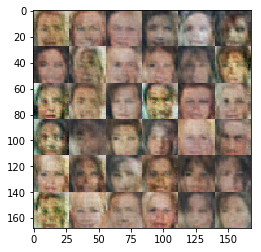

In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.